In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['database.sqlite', 'hashes.txt', 'Reviews.csv']


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import pickle



[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


Using TensorFlow backend.


In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('../input/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


**Text Preprocessing**

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'into', "should've", 'such', 'weren', 'down', 'don', 'my', "won't", 'how', 'himself', "you're", 'after', 'needn', "mightn't", 'now', 'its', 'no', 'here', "couldn't", 'him', 'should', 'aren', 'hadn', 'at', 'she', 'we', 'an', 'as', 'with', 'those', 'he', 'yours', 'while', 'under', 'you', "aren't", "isn't", 'has', 'few', 'because', 'if', "haven't", 'these', 'up', 'they', 'of', 'but', 'our', 'am', "wouldn't", 'above', "you'd", "you'll", 'did', 'some', "she's", 'do', 'wasn', 'be', 'again', 'won', 'out', "didn't", 'haven', 'which', 'only', "shouldn't", 'mustn', 'll', 'hasn', 'yourselves', 'myself', 'being', 'whom', 'until', 'itself', "weren't", 'further', 'herself', 'is', 'there', "it's", 'their', 'his', 'will', 'shan', 'i', 'had', 'doesn', 'to', 'nor', 've', 'so', "hadn't", 'what', "shan't", 'them', 'between', 'more', 'most', 'me', 'ain', "doesn't", 'o', "wasn't", 'through', 'from', 'over', 'both', 'all', 'same', 'it', 'doing', 'about', 'when', 'y', 'theirs', 'very', 'this', 'a', 'the', 'b

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|██████████| 364171/364171 [07:38<00:00, 794.09it/s] 


In [14]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    

In [15]:
final.to_pickle("./amazon.pkl")

In [16]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [17]:
# read data from pickle file from previous stage
data = pd.read_pickle("./amazon.pkl")

In [18]:
# Random sampling 
data = data.take(np.random.permutation(len(data))[:100000])

In [19]:
data['Time'] = pd.to_datetime(data['Time'])
# Sort by time
final = data.sort_values(by='Time')

print(final.shape)
print(final['Score'].value_counts())

(100000, 12)
1    84332
0    15668
Name: Score, dtype: int64


In [20]:
# Spliting into Train and test
x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

In [21]:
#Bag of words
count_vect = CountVectorizer(max_features=2000,min_df=20) 

x_train = count_vect.fit_transform(x_train)
#Normalize Data
x_train = preprocessing.normalize(x_train)
print("Train Data Size: ",x_train.shape)

x_test = count_vect.transform(x_test)
#Normalize Data
x_test = preprocessing.normalize(x_test)
print("Test Data Size: ",x_test.shape)

Train Data Size:  (70000, 2000)
Test Data Size:  (30000, 2000)


In [22]:
def find_optimal_k_multi(X_train,y_train, myList):
   
    # empty list that will hold cv scores
    cv_scores = []

    # split the train data set into cross validation train and cross validation test
    X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.3)

    for i in myList:
        nb = MultinomialNB(alpha = i)
        model = nb.fit(X_tr, y_tr)

        # predict the response on the crossvalidation train
        pred = model.predict(X_cv)

        # evaluate CV accuracy
        acc = f1_score(y_cv, pred)
        cv_scores.append(acc)
        
    # changing to misclassification error
    MSE = [x for x in cv_scores]

    # determining best alpha
    optimal_alpha = myList[MSE.index(max(MSE))]
    print('\nThe optimal alpha is ', optimal_alpha)


    plt.figure(figsize=(10,6))
    plt.plot(myList,MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. alpha Value')
    plt.xlabel('alpha')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_alpha


The optimal alpha is  0.05
the misclassification error for each k value is :  [0.919 0.919 0.919 0.919 0.919 0.924 0.927 0.932 0.933 0.933 0.933 0.933
 0.933 0.933 0.933 0.933 0.933]
0.05


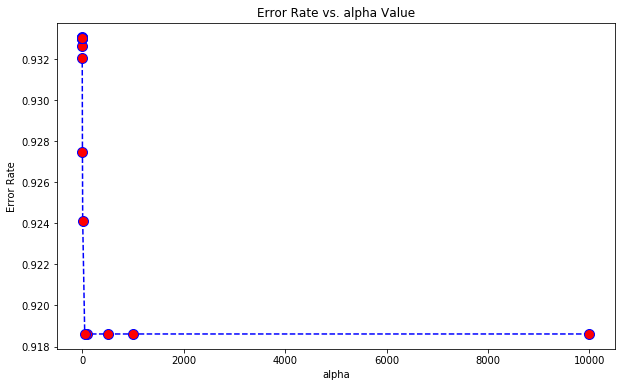

In [43]:
from sklearn.naive_bayes import MultinomialNB

alpha = 10000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00001
optimal_alpha = find_optimal_k_multi(x_train ,y_train,alpha)

print(optimal_alpha)

In [44]:
# This function plots the confusion, precision and recall matrices
def plot_confusion_matrix(x_test, y_pred):
    C = confusion_matrix(x_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
   
    B =(C/C.sum(axis=0))
 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Accuracy on test set: 86.247%
Precision on test set: 0.859
Recall on test set: 0.996
F1-micro-Score on test set: 0.862


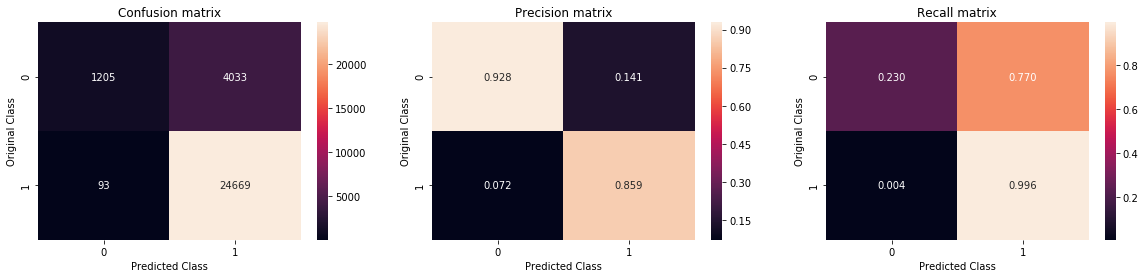

In [45]:
# instantiate learning model k = optimal_k
mn = MultinomialNB(alpha = optimal_alpha)
model = mn.fit(x_train, y_train)


# predict the response
pred = mn.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

**OBSERVATION**
* Taking a sample of 100000 data and splitting it into 70000 train data and 30000 test data.
* Writting  a function to find the optimal value of alpha = 0.05
* The F1 score is found to be 86.2% using Multinomial Naive Bayes using Bag of Words Featurization

In [46]:

def find_optimal_k_bernolli(X_train,y_train, myList):
   
    # empty list that will hold cv scores
    cv_scores = []

    # split the train data set into cross validation train and cross validation test
    X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.3)

    for i in myList:
        bb = BernoulliNB(alpha = i)
        model = bb.fit(X_tr, y_tr)

        # predict the response on the crossvalidation train
        pred = model.predict(X_cv)

        # evaluate CV accuracy
        acc = f1_score(y_cv, pred)
        cv_scores.append(acc)
        
    # changing to misclassification error
    MSE = [x for x in cv_scores]

    # determining best alpha
    optimal_alpha = myList[MSE.index(max(MSE))]
    print('\nThe optimal alpha is ', optimal_alpha)


    plt.figure(figsize=(10,6))
    plt.plot(myList,MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. alpha Value')
    plt.xlabel('alpha')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_alpha


The optimal alpha is  0.001
the misclassification error for each k value is :  [0.92  0.92  0.917 0.896 0.896 0.926 0.934 0.937 0.938 0.938 0.938 0.938
 0.938 0.938 0.938 0.938 0.938]
0.001


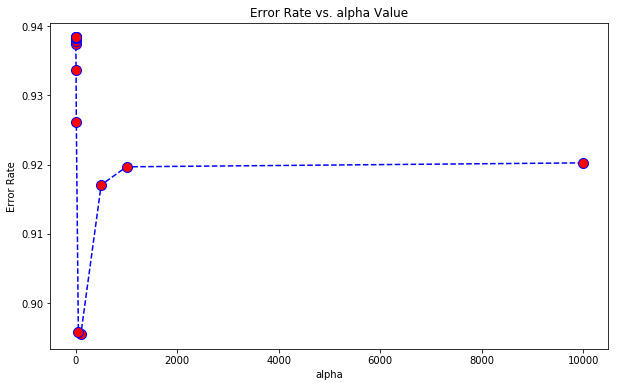

In [47]:
from sklearn.naive_bayes import BernoulliNB

alpha = 10000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00001
optimal_alpha = find_optimal_k_bernolli(x_train, y_train, alpha)

print(optimal_alpha)

Accuracy on test set: 88.223%
Precision on test set: 0.938
Recall on test set: 0.918
F1-micro-Score on test set: 0.882


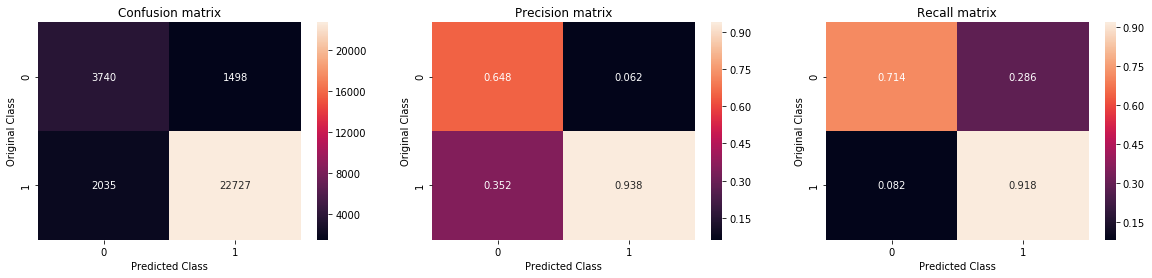

In [48]:
# instantiate learning model k = optimal_k
bb = BernoulliNB(alpha = optimal_alpha)
model = bb.fit(x_train, y_train)


# predict the response
pred = bb.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

**OBSERVATION**
* The optimal value of alpha = 0.001
* The F1 score is found to be 88.2% using Bernoulli Naive Bayes using Bag of Words featurization

# Feature Importance

In [29]:
def show_most_informative_features(vectorizer, clf, n=50):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,mn)

			Negative						Positive
________________________________________________________________________________________________
	-10.5211	yuck           				-4.3273	tast           
	-10.4700	mislead        				-4.3413	love           
	-10.3781	rancid         				-4.3487	like           
	-10.3209	trash          				-4.3544	great          
	-10.2947	resembl        				-4.3916	good           
	-10.2010	sucralos       				-4.5248	flavor         
	-10.1997	lie            				-4.6234	use            
	-10.1230	evo            				-4.6446	product        
	-10.1167	skip           				-4.7207	one            
	-10.1099	moth           				-4.8084	tri            
	-10.0851	cancel         				-4.8163	tea            
	-10.0681	thrown         				-4.8871	coffe          
	-10.0529	rope           				-4.9122	make           
	-10.0500	worst          				-4.9814	get            
	-10.0450	garbag         				-5.1237	buy            
	-10.0348	bug            				-5.1557	best           
	-10.0337	mold           				

In [30]:
show_most_informative_features(count_vect,bb)

			Negative						Positive
________________________________________________________________________________________________
	-7.3834	moth           				-1.2018	like           
	-7.2102	mole           				-1.2046	tast           
	-7.1658	yuck           				-1.2660	love           
	-7.0055	mislead        				-1.2782	good           
	-6.9341	catnip         				-1.2852	great          
	-6.9002	rope           				-1.4299	flavor         
	-6.8837	bpa            				-1.4882	one            
	-6.8674	bulli          				-1.4883	use            
	-6.8357	evo            				-1.5357	tri            
	-6.8202	miso           				-1.5716	product        
	-6.8202	sucralos       				-1.6446	make           
	-6.8049	rancid         				-1.7058	get            
	-6.7605	margarita      				-1.9043	buy            
	-6.7605	trash          				-1.9058	time           
	-6.7319	rabbit         				-1.9401	amazon         
	-6.7179	mio            				-1.9544	would          
	-6.7042	bergamot       				-1.9575	best     

# TF-IDF

In [49]:
#TF-IDF
from sklearn.model_selection import train_test_split

# Spliting into Train and test
x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

In [50]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000, min_df=10) #Using bi-grams
x_train = tfidf.fit_transform(x_train)
#Normalize Data
x_train = preprocessing.normalize(x_train)
print("Train Data Size: ",x_train.shape)
x_test = tfidf.transform(x_test)
#Normalize Data
x_test = preprocessing.normalize(x_test)
print("Test Data Size: ",x_test.shape)

Train Data Size:  (70000, 2000)
Test Data Size:  (30000, 2000)



The optimal alpha is  0.01
the misclassification error for each k value is :  [0.92  0.92  0.92  0.92  0.92  0.926 0.929 0.934 0.934 0.935 0.935 0.935
 0.935 0.935 0.935 0.935 0.935]
0.01


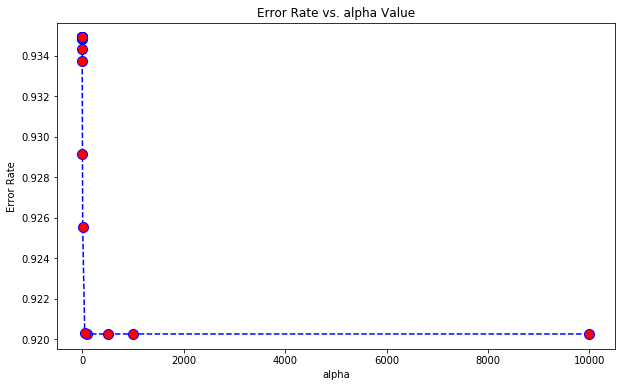

In [51]:
from sklearn.naive_bayes import MultinomialNB

alpha = 10000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00001
optimal_alpha = find_optimal_k_multi(x_train ,y_train,alpha)

print(optimal_alpha)

Accuracy on test set: 86.250%
Precision on test set: 0.860
Recall on test set: 0.996
F1-micro-Score on test set: 0.863


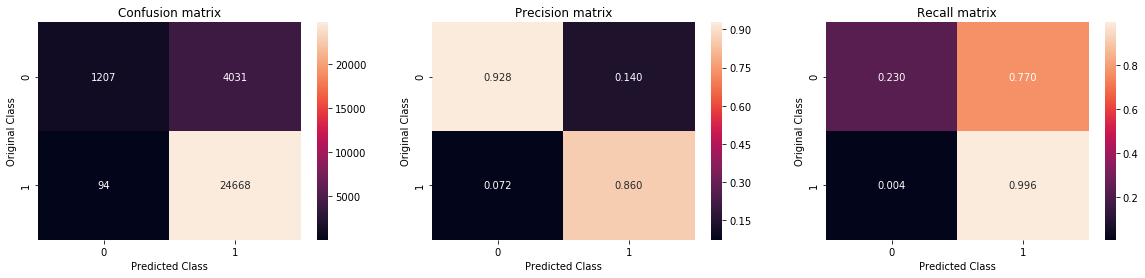

In [52]:
# instantiate learning model k = optimal_k
mn = MultinomialNB(alpha = optimal_alpha)
model = mn.fit(x_train, y_train)


# predict the response
pred = mn.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

**OBSERVATION**
* Writting  a function to find the optimal value of alpha = 0.01
* The F1 score is found to be 86.3% using Multinomial Naive Bayes using TF-IDF Featurization technique.


The optimal alpha is  0.05
the misclassification error for each k value is :  [0.919 0.918 0.916 0.896 0.897 0.927 0.933 0.938 0.938 0.939 0.939 0.939
 0.939 0.939 0.939 0.939 0.939]
0.05


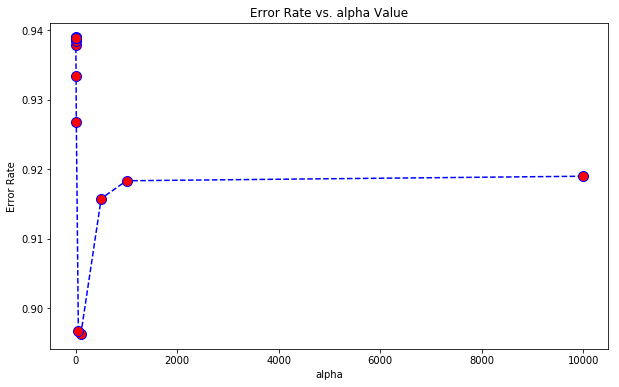

In [53]:
from sklearn.naive_bayes import BernoulliNB

alpha = 10000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00001
optimal_alpha = find_optimal_k_bernolli(x_train ,y_train,alpha)

print(optimal_alpha)

Accuracy on test set: 88.227%
Precision on test set: 0.938
Recall on test set: 0.918
F1-micro-Score on test set: 0.882


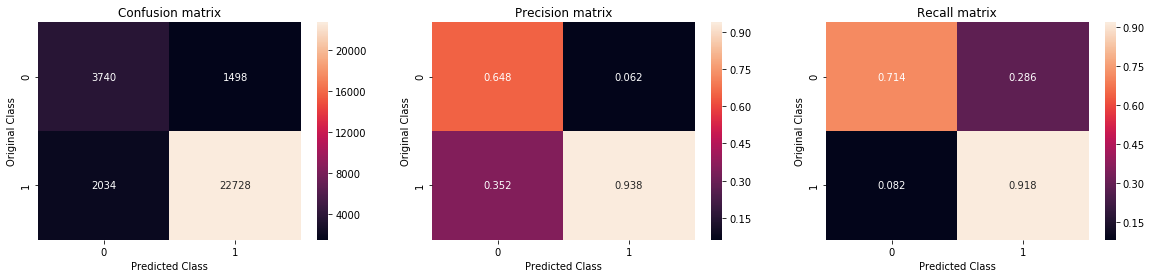

In [54]:
# instantiate learning model k = optimal_k
bb = BernoulliNB(alpha = optimal_alpha)
model = bb.fit(x_train, y_train)


# predict the response
pred = bb.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

**OBSERVATION**
* Writting  a function to find the optimal value of alpha = 0.05
* The F1 score is found to be 88.2% using Bernolli Naive Bayes using TF-IDF Featurization technique.

Feature importance

In [55]:
show_most_informative_features(tfidf,mn)

			Negative						Positive
________________________________________________________________________________________________
	-10.3940	wast money     				-4.9949	great          
	-10.0550	trash          				-4.9995	love           
	-9.8881	wont buy       				-5.0615	good           
	-9.8673	worst          				-5.0641	tast           
	-9.7905	threw          				-5.0804	like           
	-9.7777	disgust        				-5.0977	tea            
	-9.6915	unpleas        				-5.1396	flavor         
	-9.6539	refund         				-5.2030	coffe          
	-9.6350	one star       				-5.2111	use            
	-9.6341	buyer          				-5.2369	product        
	-9.6291	tasteless      				-5.3253	one            
	-9.5686	diarrhea       				-5.4010	tri            
	-9.5619	ruin           				-5.4418	make           
	-9.5329	page           				-5.5000	get            
	-9.5151	vomit          				-5.5597	best           
	-9.4425	shame          				-5.5796	price          
	-9.4348	gross          				-5.5854	buy    

In [38]:
show_most_informative_features(tfidf,bb)

			Negative						Positive
________________________________________________________________________________________________
	-7.0825	wast money     				-1.2018	like           
	-6.7899	wont buy       				-1.2046	tast           
	-6.7605	trash          				-1.2660	love           
	-6.5520	refund         				-1.2782	good           
	-6.5403	buyer          				-1.2852	great          
	-6.4408	tasteless      				-1.4299	flavor         
	-6.4408	threw          				-1.4882	one            
	-6.4303	mate           				-1.4883	use            
	-6.4303	oreo           				-1.5357	tri            
	-6.4303	vomit          				-1.5716	product        
	-6.4200	diarrhea       				-1.6446	make           
	-6.3996	shame          				-1.7058	get            
	-6.3796	tazo           				-1.9043	buy            
	-6.3796	worst          				-1.9058	time           
	-6.3503	coke           				-1.9401	amazon         
	-6.3503	disgust        				-1.9544	would          
	-6.3407	one star       				-1.9575	best     

In [2]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Featurization","Model","Alpha","F1 score(in %)","Accuracy(in %)"]
x.add_row(["Bag of Words", "Multinomial Naive Bayes", 0.05,86.2,86.2])
x.add_row(["Bag of Words", "Bernolli Naive Bayes", 0.001,88.2,88.2])
x.add_row(["TF-IDF", "Multinomial Naive Bayes", 0.01,86.3,86.25])
x.add_row(["TF-IDF", "Bernolli Naive Bayes", 0.05,88.2,88.22])

print(x)

+---------------+-------------------------+-------+----------------+----------------+
| Featurization |          Model          | Alpha | F1 score(in %) | Accuracy(in %) |
+---------------+-------------------------+-------+----------------+----------------+
|  Bag of Words | Multinomial Naive Bayes |  0.05 |      86.2      |      86.2      |
|  Bag of Words |   Bernolli Naive Bayes  | 0.001 |      88.2      |      88.2      |
|     TF-IDF    | Multinomial Naive Bayes |  0.01 |      86.3      |     86.25      |
|     TF-IDF    |   Bernolli Naive Bayes  |  0.05 |      88.2      |     88.22      |
+---------------+-------------------------+-------+----------------+----------------+


# Conclusion
1. The results in terms of accuracy and f1 score, we see that Bernolli Naive Bayes perform well in both featurization techniques (Bag of Words and TF-IDF) with alpha values being same for three featurization(BOW, TF-IDF, TF-IDF) and different only for one(BOW in Bernolli Naive Bayes).

2. The accuracy of the model is better for TF-IDF because the we take Uni-gram and Bi-gram as features and give weights to a feature depending on its occurence.

3. Bernolli Naive Bayes performs well because it counts the occurence of features and also the non occurence of words. 

I choose Multinomial Naive Bayes and Bernolli Naive Bayes because both are very good for predicting a particular class by counting the occurence of feature/features and non occuring of the feature/features, where Multinomial Naive Bayes counts the frequency for occurence of multiple feature and Bernolli Naive Bayes counts the occurence of a single feature and counts for the same feature that do not occur.